Tutorial 2: Normalizing CITE-seq data
====================================================================

In this tutorial, we demonstrate how to use the ImmunoPheno library to normalize the protein data from a CITE-seq dataset of human tonsil cells including 38 antibodies. The data for this example is provided as an AnnData `.h5ad` [file](https://www.dropbox.com/scl/fi/hfnjazttwc0wucm345vbl/tonsil.h5ad?rlkey=m9zl9olxh6klkgzqmdvdpmtyc&st=cre1rmjy&dl=0). In this file, empty droplets and cells that do not pass the quality controls have been already filtered out and the remaining cells have been annotated using standard software for single-cell RNA-seq data analysis such as [scanpy](https://scanpy.readthedocs.io/en/stable/), [Seurat](https://satijalab.org/seurat/), and [singleR](https://bioconductor.org/packages/release/bioc/html/SingleR.html).

In [1]:
# Choose the adequate plotly renderer for visualizing plotly graphs in your system
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [3]:
import pandas as pd
import scanpy as sc
from immunopheno.data_processing import ImmunoPhenoData
from immunopheno.plots import plot_UMAP
from immunopheno.models import plot_all_fits, plot_ab_fit

tonsil = sc.read_h5ad("tonsil.h5ad")

Note that the AnnData object contains both the gene and (unnormalized) protein expression data,

In [4]:
tonsil.var["feature_types"].value_counts()

feature_types
Gene Expression     1705
Antibody Capture      38
Name: count, dtype: int64

Cell identities were annotated using Azimuth and stored in the slot `'azimuth_names'`,

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



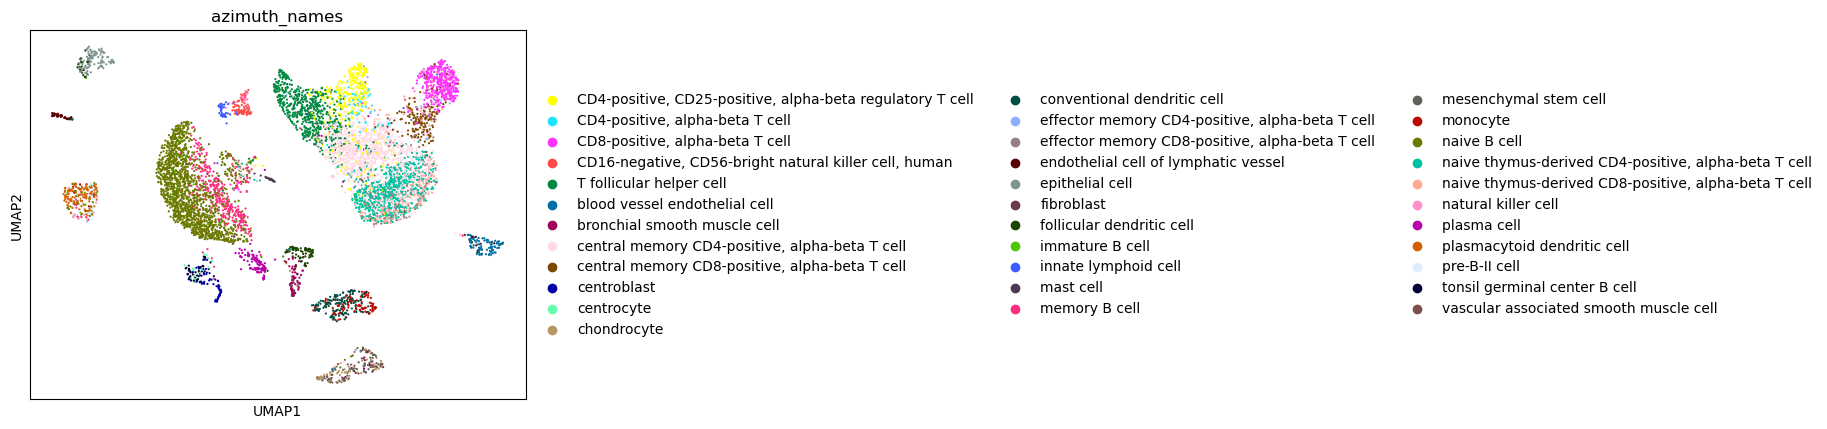

In [6]:
sc.pl.umap(tonsil, color=['azimuth_names'], size=10)

To normalize the protein data, we first create an `ImmunoPhenoData` instance. We can provide the ADT, gene expression, and cell annotation tables as `.csv` files or as pandas dataframes where each row corresponds to a cell. Alternatively, we can provide a `scanpy` (`AnnData`) object in the argument `scanpy=` of `ImmunoPhenoData`,

In [7]:
tonsil_ipd = ImmunoPhenoData(scanpy=tonsil, scanpy_labels = 'azimuth_names')

The antibody labels are stored in `protein.columns`:

In [8]:
tonsil_ipd.protein.columns

Index(['CD3', 'CD8', 'CD56', 'CD19-1', 'CD33-1', 'CD11c', 'CD123', 'CD4-1',
       'CD16', 'CD25', 'CD20', 'CD335', 'Podoplanin', 'IgM', 'HLA-DR', 'CD11b',
       'CD35', 'TCRab', 'CD163-1', 'CD83-1', 'CD38-1', 'CD127', 'Ep-CAM',
       'CD10', 'CD90', 'TCRrd', 'TCRVJ', 'CD206', 'CD117', 'CD279', 'IgD',
       'CD185', 'CD194', 'CD196', 'CD161', 'CD39', 'CD26', 'CD183'],
      dtype='object')

We use the function `fit_all_antibodies()` to fit 1- to 3-component mixture models for each antibody. For CITE-seq data we choose negative binomial components. The funtion then uses Akaike Information Criterion (AIC) to determine the best fit for each antibody, and assigns the first component as the background component, consisting of cells that do not express the corresponding antigen

In [9]:
tonsil_ipd.fit_all_antibodies(model="nb")

  0%|          | 0/38 [00:00<?, ?it/s]

Number of 3 component models: 25
Number of 2 component models: 12
Number of 1 component models: 1
Antibodies of 1 component models:
CD35


We can visually inspect the above fits and override the number of components or eliminate some antibodies from downstream analyses if we decide so. For example, we can look at CD3: 

In [10]:
plot_ab_fit(tonsil_ipd, "CD3")

The red component represents the background and the green and blue components are signal. From this plot, we observe that although the 3-component model has a slightly better AIC than the 2-component model, and was therefore selected by ImmunoPheno, the 2-component model likely makes more sense. To override ImmunoPheno’s automatic selection, we use:

In [11]:
tonsil_ipd.select_mixture_model("CD3", 2)

If we were to remove this antibody, we would use instead the command ```tonsil_ipd.remove_antibody("CD3")```.

We can now use these fits to filter cells and normalize protein expression values. We may want to filter out cells that express most of the profiled proteins or a very small number of proteins. In this example, we will filter out cells expressing less than 10% of the profiled proteins (`bg_expr_threshold = 0.10`) or more than 75% of the profiled proteins (`sig_expr_threshold = 0.75`). In the normalization model implemented in ImmunoPheno, the average expression level of a protein across cells expressing the protein is a parameter. In this example, we choose a separation of 1.5 standard deviations (`bg_cell_z_score = 1.5`) from the expression value of cells that do not express the protein (i.e. the zero expression). Putting all elements together, we have:

In [12]:
tonsil_ipd.normalize_all_antibodies(bg_expr_threshold = 0.10, sig_expr_threshold = 0.75, bg_cell_z_score = 1.5)

  0%|          | 0/38 [00:00<?, ?it/s]

In total 276 cells have been filtered based on the aforementioned criteria. We can visualize the UMAP representation of the normalized protein expression space,

In [13]:
plot_UMAP(tonsil_ipd, normalized=True).update_traces(marker={'size': 2}).update_layout(autosize=False, width=1000, height=400)

As expected, mRNA cell populations appear more intermixed in the UMAP representation of the non-normalized protein expression data,

In [14]:
plot_UMAP(tonsil_ipd, normalized=False).update_traces(marker={'size': 2}).update_layout(autosize=False, width=1000, height=400)

Increasing the separation between the background and average protein expression will lead to a more fragmented normalized protein expression space,

In [15]:
tonsil_ipd.normalize_all_antibodies(bg_expr_threshold = 0.10, sig_expr_threshold = 0.75, bg_cell_z_score = 10)
plot_UMAP(tonsil_ipd, normalized=True).update_traces(marker={'size': 2}).update_layout(autosize=False, width=1000, height=400)

  0%|          | 0/38 [00:00<?, ?it/s]

On the other hand, a more aggressive filtering will eliminate a larger number of cells

In [16]:
tonsil_ipd.normalize_all_antibodies(bg_expr_threshold = 0.15, sig_expr_threshold = 0.75, bg_cell_z_score = 1.5)
plot_UMAP(tonsil_ipd, normalized=True).update_traces(marker={'size': 2}).update_layout(autosize=False, width=1000, height=400)

  0%|          | 0/38 [00:00<?, ?it/s]

Note that in this case we still have representation of all mRNA cell populations, and the mRNA cell populations appear better delimited in the UMAP representation, but 1,642 cells have been filtered out from the dataset.

Once we have found a setting for the normalization parameters that we are happy with, we can save the filtered and normalized protein expression table as a `.csv` file, 

In [17]:
tonsil_ipd.normalized_counts.to_csv("tonsil_normalized_protein.csv")

or directly incorporate it into the scanpy object,

In [18]:
tonsil.protein = tonsil[tonsil_ipd.normalized_counts.index, tonsil_ipd.protein.columns]
tonsil.protein.X = tonsil_ipd.normalized_counts

Finally, we can visualize the normalized protein expression values in the mRNA UMAP representation,

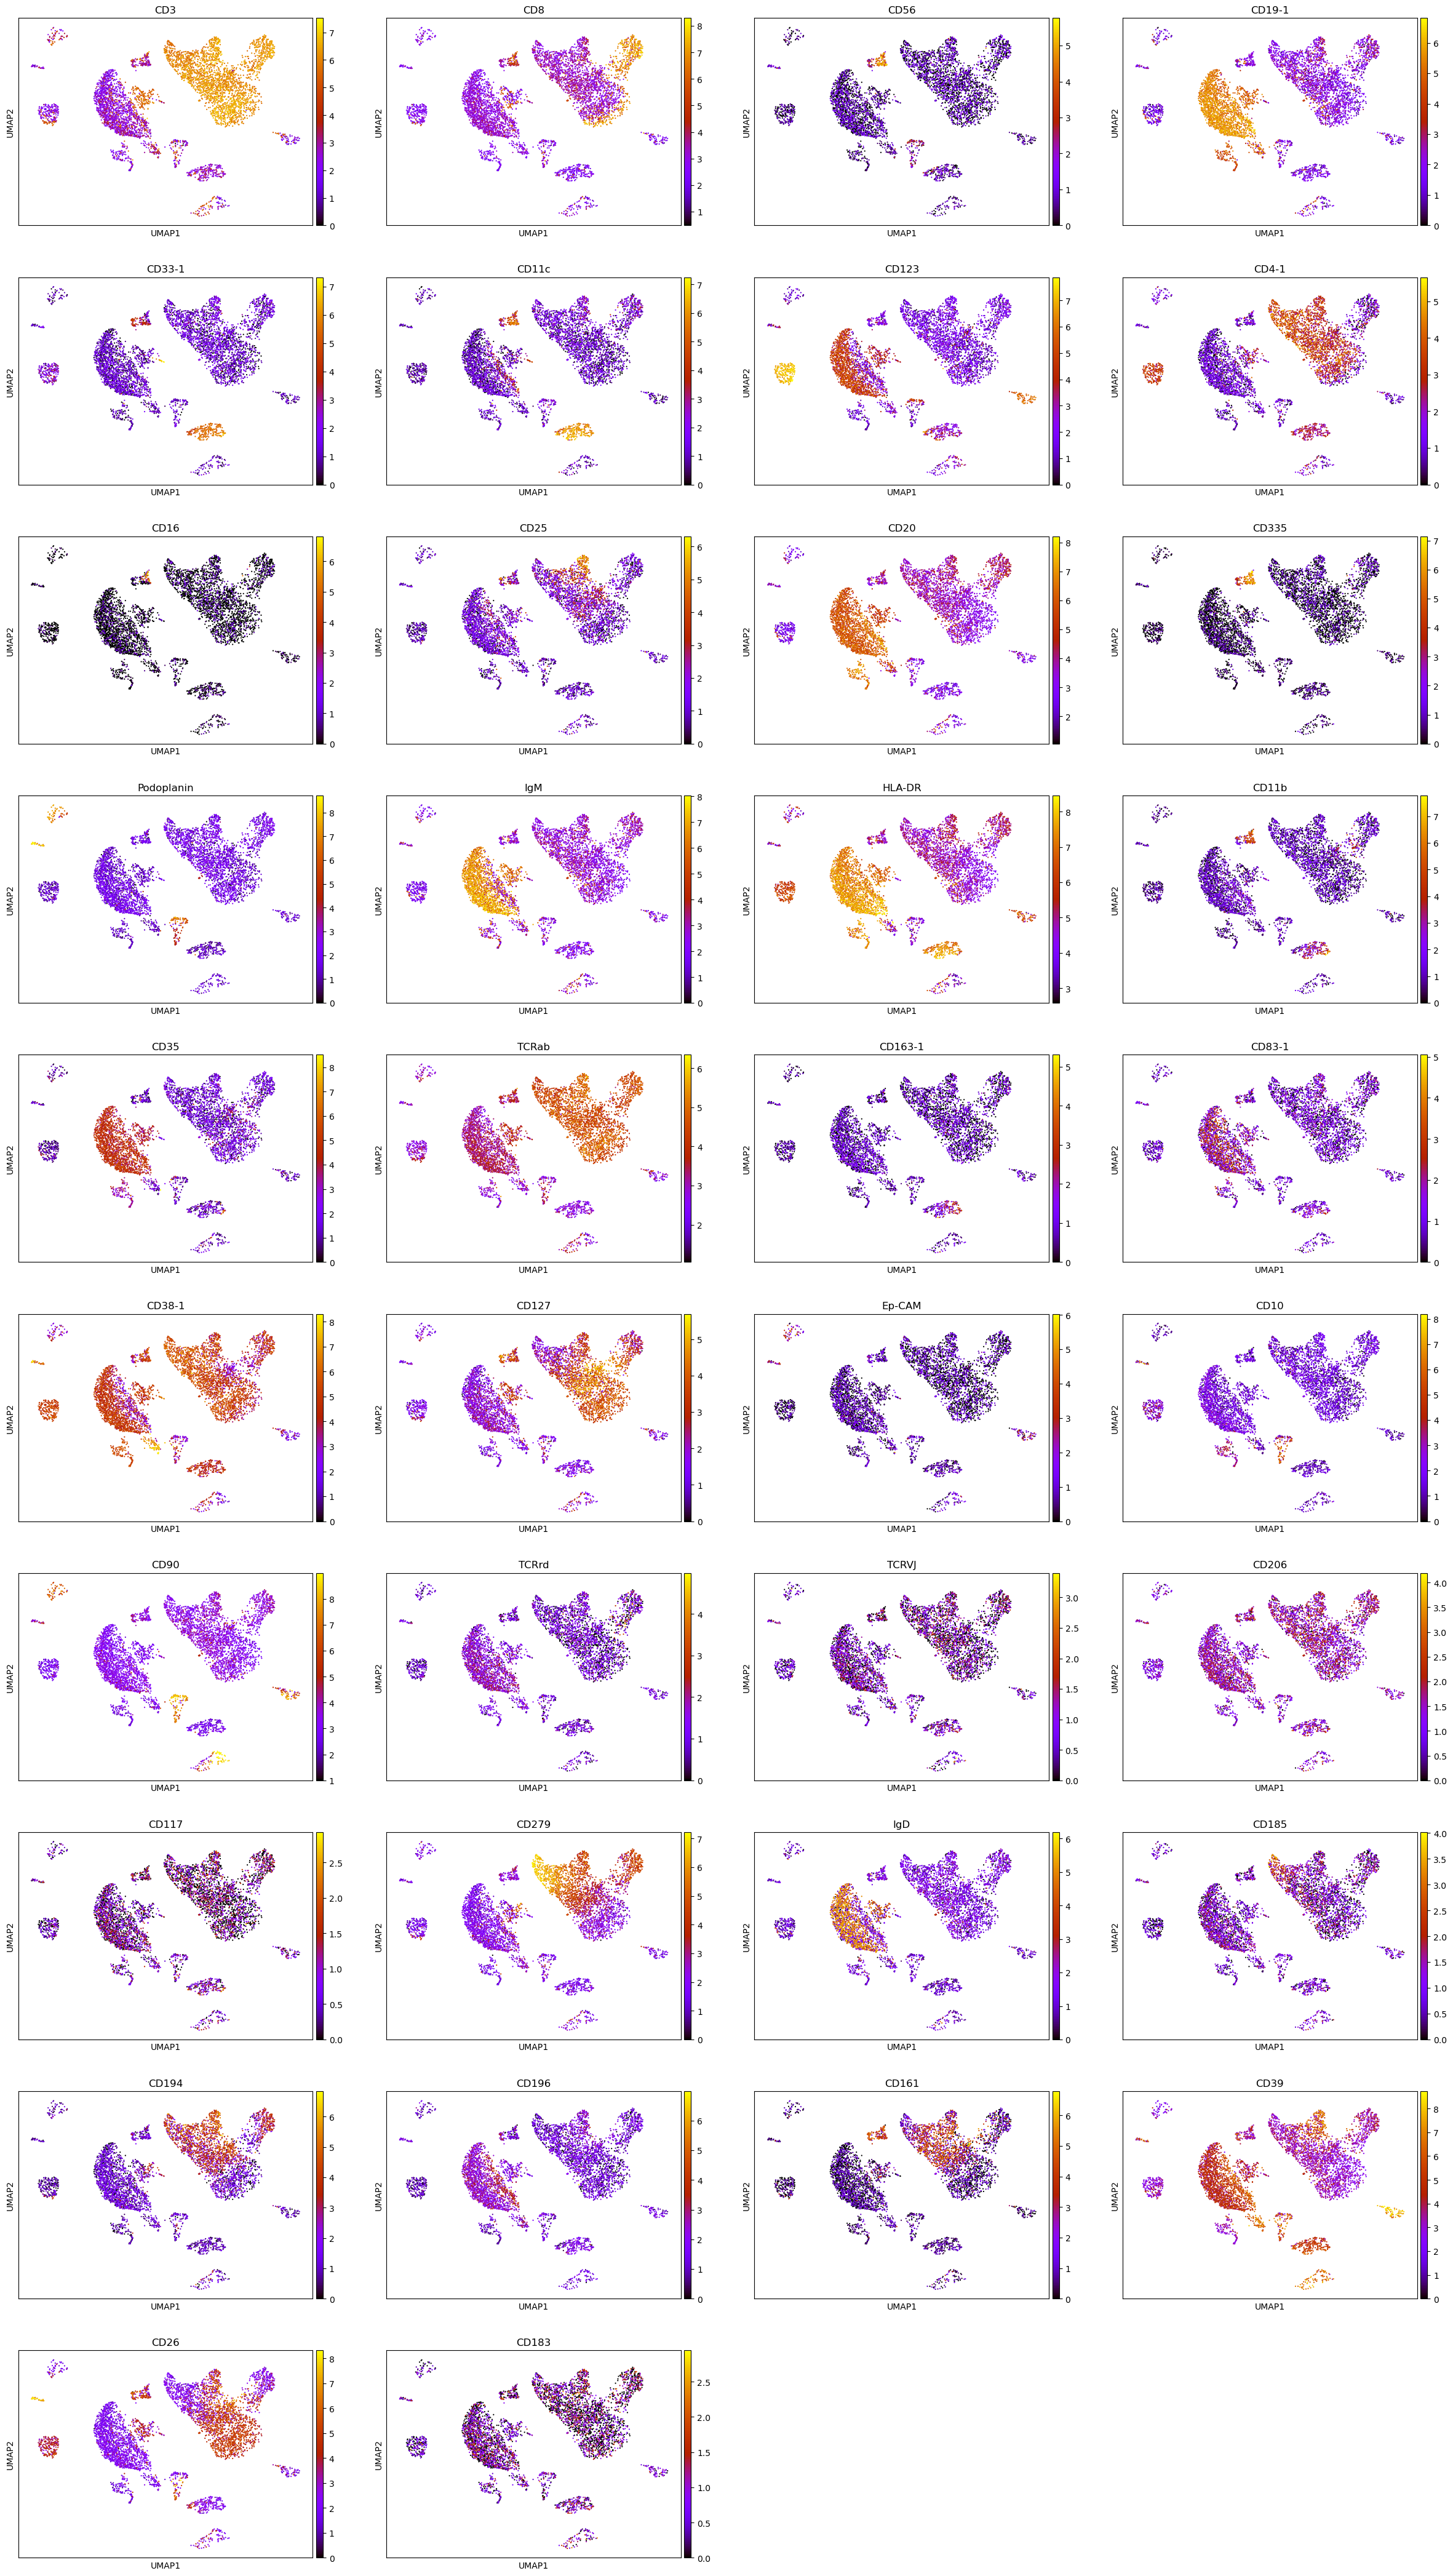

In [19]:
sc.pl.umap(tonsil.protein, color=tonsil_ipd.protein.columns, size=10, color_map = "gnuplot")